<a href="https://colab.research.google.com/github/eta-lab/cooling-around/blob/main/models/mrt2_XGBoost_futurePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [1]:
# Install XGBoost
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release


# import all the usual suspects :)
import os
from google.colab import drive
import pickle
 
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score, accuracy_score
 
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# boosting libraries from XGBoost
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

     |████████████████████████████████| 166.7 MB 16 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
XGBoost version: 1.4.2


# LOAD THE DATA and MODEL

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

\n
... The notebook used to define the features and tune/train the model are available here: 

## Mount drive and define folders that hold the data files

In [46]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Upload files with pre-processed data and model

In [47]:
# Training/test set, Features (X variables) during occupied hours:
df_X = pickle.load(open(DATA_PATH + '/X_occHrs.p','rb'))
     
# Training/test set, Prediction Target (y variable) during occupied hours:
df_y = pickle.load(open(DATA_PATH + '/y_occHrs.p','rb'))


# Additionally, Prediciton Target during all hours (including unoccupied)
df_y_allHrs = pickle.load(open(DATA_PATH + '/y_allTimes.p', 'rb'))

# Forecasted Features (Features only, years 2020-2080): 
df_future = pickle.load(open(DATA_PATH + '/future_inputs.p','rb'))
# Should match the columns of training set: e.g., df_X_occHrs
# features:  ['temp' 'last_temp_2' 'last_temp_4' 'temp_ave_48hr'
# 'temp_max_24hr' 'temp_min_24hr' 'day_cos' 'day_sin']

# load XGBoost trained model:
model_fitted = pickle.load(open(DATA_PATH + '/fitted_xgb.p', "rb"))

## Array the data (i.e., convert to numpy arrays) for use by the model

In [48]:
# Convert features and target and time stamps to separate numpy arrays
x = df_X.copy().to_numpy()
y = df_y.copy().to_numpy().reshape(-1,1) # need to reshape Y which contains 1 features (currently it's 0) 
t = df_X.index.copy() # create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)

# NB this artificial split does something to the shape that the model requires (!!?)
x_, ignore_X, y_, ignore_y, time_stamp, ignore_t = train_test_split(x, y, t, shuffle = False, test_size= 0.00001)

# check
print("dimensions of features array, and Y:", x_.shape, y_.shape)
print("dimensions of time stamp for train and test sets:", time_stamp.shape)

dimensions of features array, and Y: (1247, 8) (1247, 1)
dimensions of time stamp for train and test sets: (1247,)


## MSE and Visually examine predicted indoor air temp against test set 

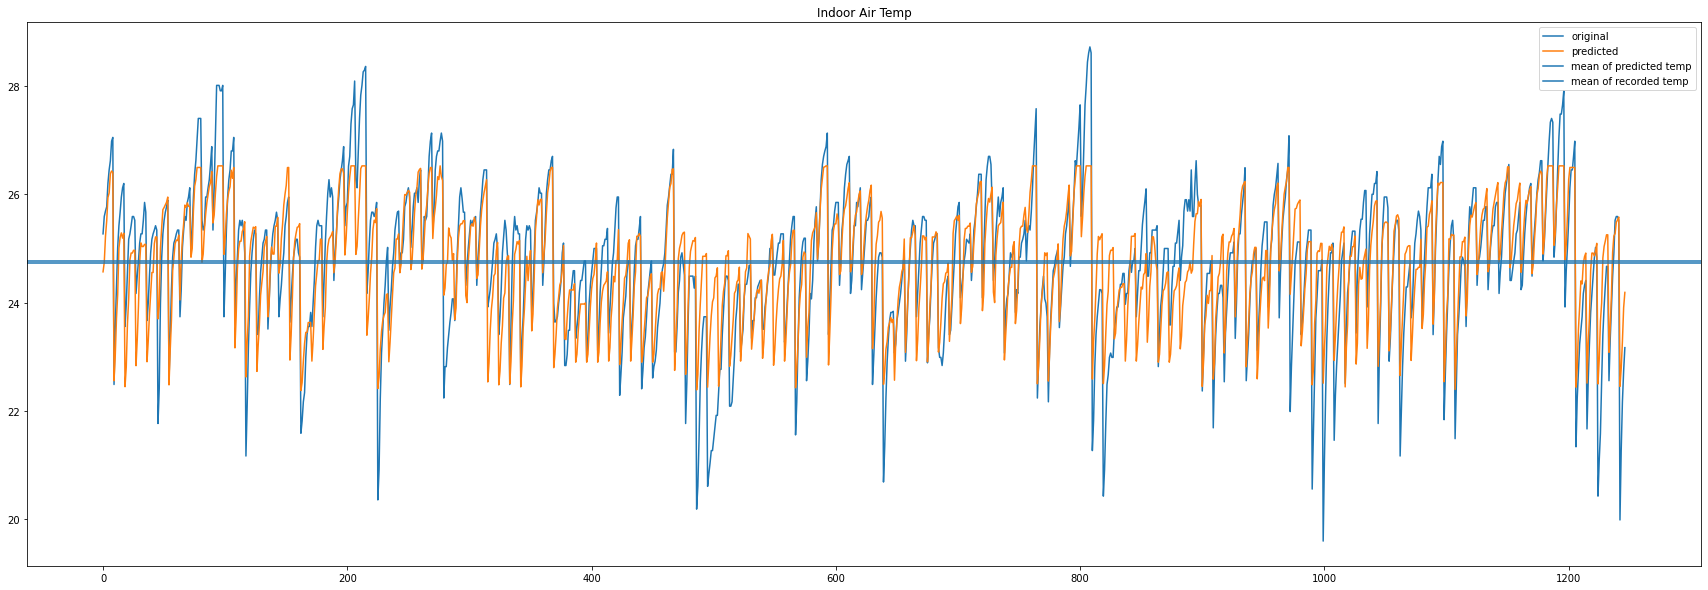

In [49]:
# Visualize Predictions of indoor air temp (using fitted model)
# Note: this is not a depiction of 'fit' because we trained on 85% of this data 
# for mean squared error and/or other measurements of fitness see training notebook

y_pred = model_fitted.predict(x_)

mean_pred = y_pred.mean()
mean_temp = y_.mean()

plt.figure(figsize=(30,10))
x_ax = range(len(y_pred))
plt.plot(x_ax, y_, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.axhline(y=mean_pred, label = "mean of predicted temp")
plt.axhline(y=mean_temp, label = "mean of recorded temp")
plt.title("Indoor Air Temp")

plt.legend()
plt.show()

⛳ On average it is close... but Prediction still could be better at catching the peaks! Quantify this conservativeness to be able to comment on it...and if possible propogate to an estimate of how 'conservating' the eventually predicted MRT is ...

#  DEFINE FUNCTIONS: Comfortable Temp, MRT, Dew Point...

###  'Comfortable' operative temperature

Finding the (hourly) 'comfortable' operative temperature based on average outdoor air temperatures

The adaptive comfort model's stipulated 'comfortable oeprative temperature' which is defined as a function of the average outdoor air temperature.

Tcomf = 0.31*[Ta,out] + 17.8

where: Tcomf = indoor comfortable temperature
Ta,out = mean outdoor air temperature*

*mean outdoor temperature as the input variable for the adaptive model. It is based on the arithmetic average of the mean daily outdoor temperatures over no fewer than 7 and no more than 30 sequential days prior. We will use 7.


sources:
ANSI/ASHRAE Standard 55-2017, Thermal Environmental Conditions for Human Occupancy. de Dear, R., & Brager, G. S. (2002). Thermal comfort in naturally ventilated buildings: revisions to ASHRAE Standard 55. Energy and Buildings, 34, 549-561.

In [50]:
def get_comfy_opTemperature (outdoor_air):

    # Calculate average of previous week's outdoor air temp (for calculating comfortable op temp)
    out_7dayAverage = outdoor_air.rolling(168, min_periods=12).mean() 

    # Calculate adaptive model comfort temp
    return 0.31*out_7dayAverage +17.8 + 2.5

### Local average MRT for comfort

Use comfy threshold to find the (hourly) local MRT necessary given background indoor temps

The desired 'outcome' is whether the current hour is 'comfortable', based on comparing the indoor air temperature and the adaptive comfort model's stipulated 'comfortable oeprative temperature' (see previous block). 

GAP = op_temp_comfy - op_temp

where

op_temp = 0.5*(air_temp + MRT)

i.e., indoor operative temperature is an average of air temperature and mean radiant temperature, MRT

If the GAP is 0, then:

op_temp_comfy == op_temp

op_temp_comfy == 0.5*(air_temp + MRT)

And re-written to find what the gap is in terms of MRT:

MRT = 2*op_temp_comfy - air_temp

In [51]:
def get_required_MRT(comfy_operativeTemp,indoor_airTemp): 
    # this is the gap between indoor AIR temp and desired indoor OPERATIVE temp
    return 2*comfy_operativeTemp - indoor_airTemp

### Dew Point

Estimate the hourly Dew Point

Formula for Dew Point Temp: $ T_d = \frac{c{\gamma}}{b-{\gamma}}$

where ${\gamma} = \ln(\frac{RH}{100}) + \frac{bT}{c +T} \$ 

Given:  $RH $ = relative humidity, $T$ = indoor dry bulb temp in °C, $b$ = 18.678, $c$ = 257.14 °C


In [52]:
def get_dewPoint(indoor_airTemp, rel_hum=60): 
    # this returns dew point temp, based on assumption about RH

    B = 18.678
    C = 257.14
    gamma = np.log(rel_hum/100) + ((B*indoor_airTemp)/(C + indoor_airTemp))
    return C*gamma/(B-gamma)

### Minimum View Factor of Cooling Panel(s)

The temperature of a panel should not drop below the dew point; this limits its temperature, which thus constrains the it's capacity to cool for a given view factor. Knowing the required cooling, what is the smallest possible view factor that is feasible?

Target_temp = VF x Panel_temperature + (1-VF)xIndoor_temperature


Re-arranging we get: 

VF = (Target_temp - Indoor_temp) / (Panel_temp - Indoor_temp)

In [53]:
# this returns the smallest (limiting) view factor to not exceed dew point

def get_min_viewFactor(indoor_airTemp, target_Temp, dew_Temp): 
    # Set the target as 'comfortable' operative temp
    # Set the panel temp just above dew point
    return (target_Temp - indoor_airTemp) / (dew_Temp - indoor_airTemp)

### Required panel temperature 
Given target temp (comfort), indoor air, and VF

Target_temp = VF x Panel_temperature + (1-VF) x IndoorAir_temperature


Formula for perceived temperature: $ T_{perceived} = VF*T_{panel} + \left(  1-VF \right) $

where ${\gamma} = \ln(\frac{RH}{100}) + \frac{bT}{c +T} \$ 

Panel_temp = 

# (2015-2017): back-cast non-comfortable times, and needed background MRT

In [54]:
# We don't need all the features from the X set, just the outdoor temp! 
out_air = pd.Series(x_[:,0])

# Get the target variable (indoor temp)
ind_air = pd.Series(y_[:,0])  

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT = get_required_MRT(comfy_opTmp,ind_air)

dew_Point = get_dewPoint(ind_air)

min_VF = get_min_viewFactor(ind_air, comfy_opTmp, dew_Point)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_ = pd.DataFrame({'ind_air': ind_air, 
                   'out_air':out_air,
                   'comfy_opTmp': comfy_opTmp,
                   'comfy_MRT': comfy_MRT,
                    'dew_point': dew_Point,
                    'too_hot': (ind_air>comfy_opTmp),
                    'min_VF': min_VF}).set_index(time_stamp) #recall t was the original date-time stamp df_all_X.index 

### Profile of comfort under existing conditions
What percentage of the time during the summer was the indoor temp above the comfortable temp? 

In [55]:
print('Between 2015 and 2017 is too hot indoor about', df_['too_hot'].mean().round(1)*100, 'percent of the time (during occupied hours).' )

Between 2015 and 2017 is too hot indoor about 10.0 percent of the time (during occupied hours).


### Visualize year by year:

In [56]:
# don't want to plot lines connecting rows of NANs explicitly. 
# Therefore, first merge this dataframe that only has data for days/times during occupied hours, with the longer data-time index from  a longer df that has "all" the dates
df_all = df_y_allHrs.join(df_).drop('air_tmp_ind',1) # This fills in missing rows explicitly with NaNs
 

def visualize_given_year(dat=df_all.copy(), year=2015):
    yr = year
    df_plot = dat.copy()
    # keep only summer dates, e.g., June, July and August:
    df_yr = df_plot[df_plot.index.month.isin([6,7,8]) & (df_plot.index.year == yr)]
    x_ax = df_yr.index

    # Plot 1: When is it uncomfortably hot? (time series)
    plt.figure(figsize=(15,5))
    plt.title("Plot 1: Hourly indoor conditions during occupied hours, summer of %i" %yr)
    ax1 = df_yr.loc[(df_yr['too_hot'] == True), 
                    'ind_air'].plot(marker='.', 
                                    linestyle = '', 
                                    color='magenta', 
                                    label='Uncomfortable Dry Bulb Temps [C]')
    ax2 = df_yr.loc[(df_yr['too_hot'] != True), 
                    'ind_air'].plot(marker='.', 
                                    linestyle = '', 
                                    color='g',
                                    label='Comfortable Dry Bulb Temps [C]')
    plt.grid(axis='y')
    plt.legend()
    plt.show()

    # Plot 2: MRT needs during summer (time series)
    plt.figure(figsize=(15,5))
    plt.title("Plot 2: Hourly Cooling MRT needed during occupied hours, summer of %i" %yr)
    plt.grid(axis='y')
    plt.plot(x_ax, df_yr.comfy_MRT, 
                  linestyle='',
                  marker='.', color = 'b', 
                  label="Required average MRT [C]")
    plt.plot(x_ax, df_yr.dew_point, 
                  linestyle='', 
                  marker='.', color = 'purple',
                  label="Dewpoint [C]")
    plt.legend()
    plt.show()

    # Plot 3: Minimum VF needs during summer (time series)
    plt.figure(figsize=(15,5))
    plt.title("Plot 3: Minimum panel(s) View Factor to achieve comfort, summer of %i" %yr)
    plt.grid(axis='y')
    plt.plot(x_ax, df_yr.min_VF, 
             linestyle='', 
             marker='.', color = 'black',
             label="Required View Factor")
    #plt.plot(x_ax, df_yr.dew_point, label="de", linestyle='-', marker='')
    plt.legend()
    plt.show()

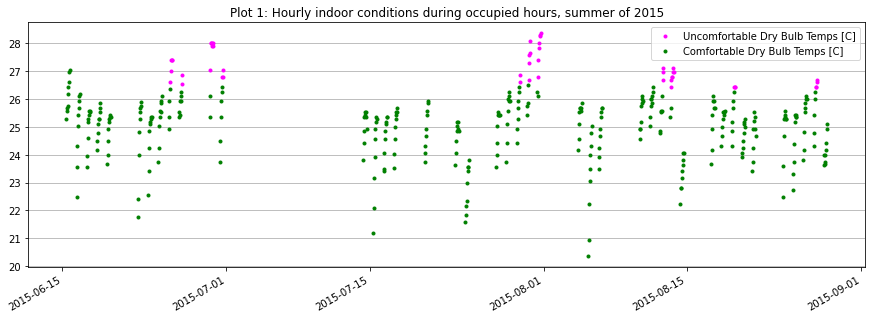

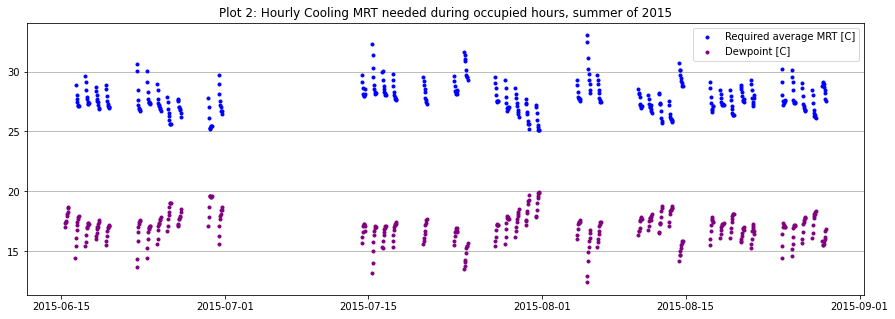

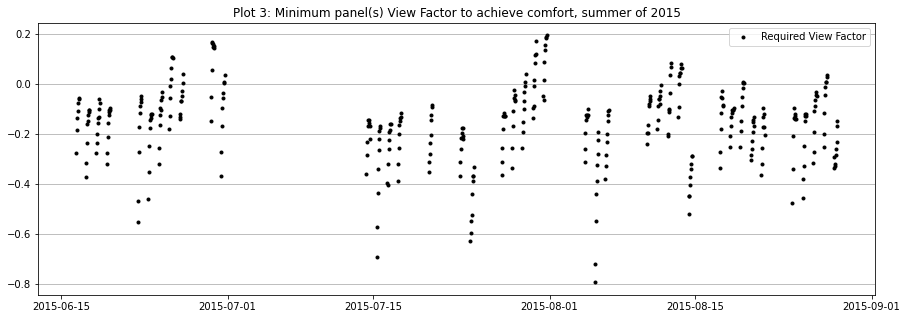

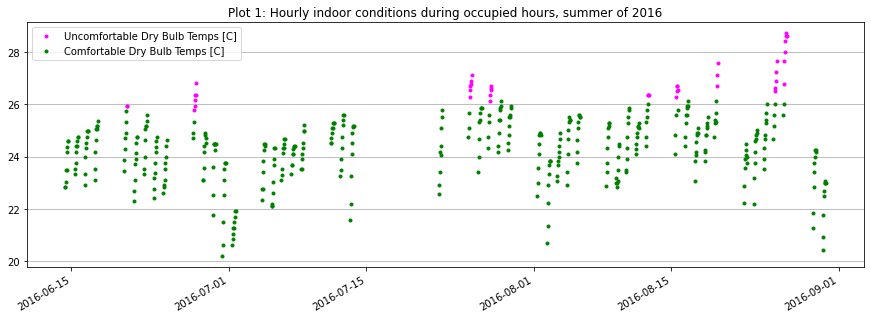

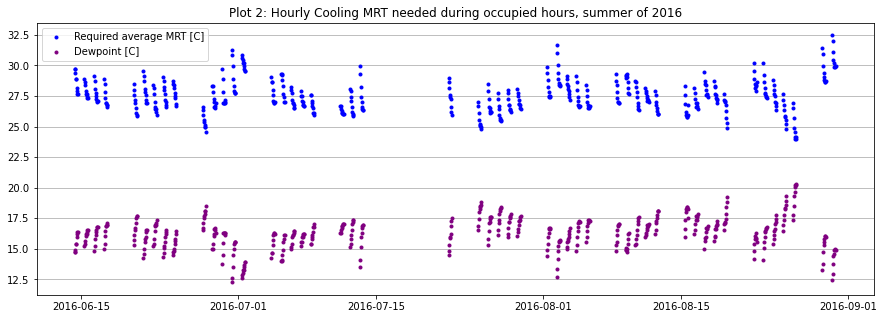

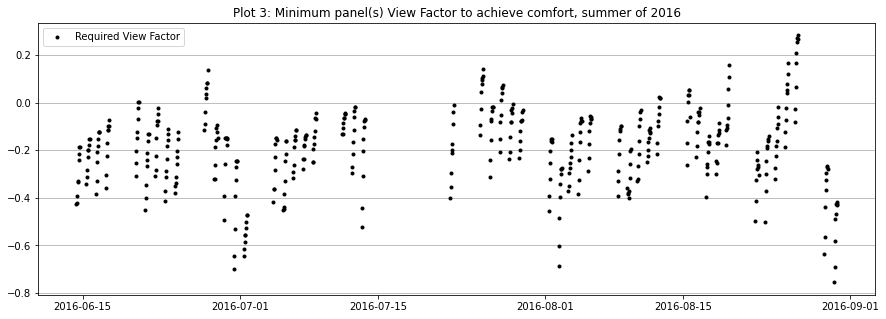

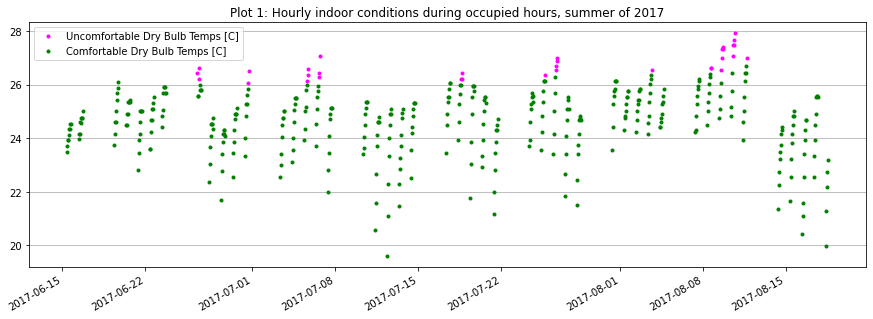

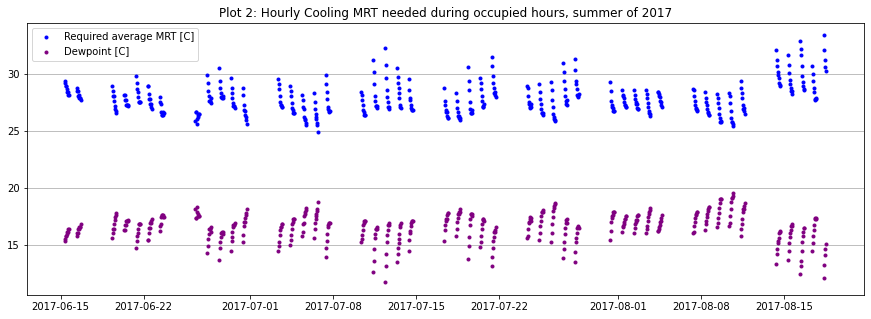

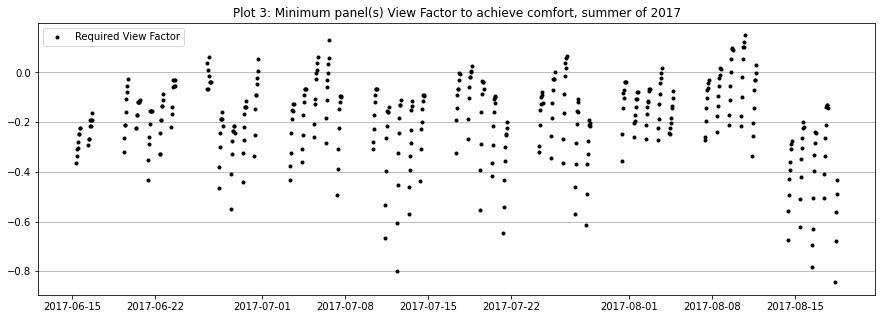

In [57]:
# Visualize 2015
visualize_given_year(df_all, 2015)

# Visualize 2016
visualize_given_year(df_all, 2016)

# Visualize 2017
visualize_given_year(df_all, 2017)

# (2050, 2080): Forecast of needed cooling based on projected outdoor

## Predictions for 2023 to 2080 under RCP 8.5

First predict indoor air temp for future years, under climate change scenario RCP 8.5

In [58]:
# 2023- 2080
# work with data set that goes to 2080
X_to_2080 = df_future.copy()

# Cut years before 2023
before2023 = pd.to_datetime('2023-06-01') #*keep last week of May (if available) for lag time
X_2023_80 = X_to_2080.query('index >= @before2023')

# Convert to numpy
x = X_2023_80.to_numpy()
t = X_2023_80.index.copy() # create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)
# Extra step to reformat in a way that doesn't throw an error inside the model's prediction function
x_all, testX, time_all, testTime = train_test_split(x, t, shuffle = False, test_size= 0.0001)

# Prediction 2025
pred_RCP_85 = model_fitted.predict(x_all)

Estimate comfortable temp, required background MRT, and dew point

In [59]:
# Change the size of the array of prediciton to match the array of the test
y_pred = pred_RCP_85.reshape(-1,1)

# Get predicted indoor temp
ind_air_85 = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

# Set the outdoor air 
out_air_85 = pd.Series(x_all[:,0]) 

# Comfortable Operative Temperature
comfy_opTmp = get_comfy_opTemperature(out_air_85)

# Average background MRT needed to achieve comfort
comfy_MRT = get_required_MRT(comfy_opTmp,ind_air_85)

# Estimate of dewpoint
dew_point = get_dewPoint(ind_air_85)

# Needed View Factor of panel(s) 
min_VF = get_min_viewFactor(ind_air_85, comfy_opTmp, dew_point)

# Example of Panel MRT at X view factor: 


# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_85 = pd.DataFrame({'ind_air': ind_air_85, 
                   'out_air':out_air_85,
                   'comfy_opTmp': comfy_opTmp,
                   'comfy_MRT': comfy_MRT,
                    'dew_point': dew_point,
                    'too_hot': (ind_air_85>comfy_opTmp),
                    'degrees_too_hot': (ind_air_85-comfy_opTmp),
                    'min_VF': min_VF}).set_index(time_all)  

Look at distribution of outdoor and indoor air temp over the years

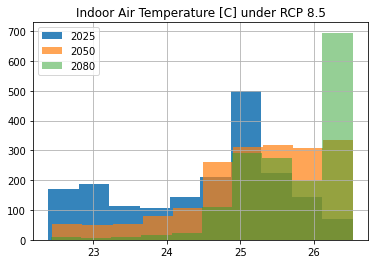

<Figure size 432x288 with 0 Axes>

In [60]:
plt.title('Indoor Air Temperature [C] under RCP 8.5')
df_85.loc[(df_85.index.year == 2025),'ind_air'].hist(alpha=0.9, label='2025')
df_85.loc[(df_85.index.year == 2050),'ind_air'].hist(alpha=0.7, label='2050')
df_85.loc[(df_85.index.year == 2080),'ind_air'].hist(alpha=0.5, label='2080')
plt.legend()
plt.show()
plt.savefig(FIGURES_PATH + '/hist_indAirTemps_RCP85.pdf') 

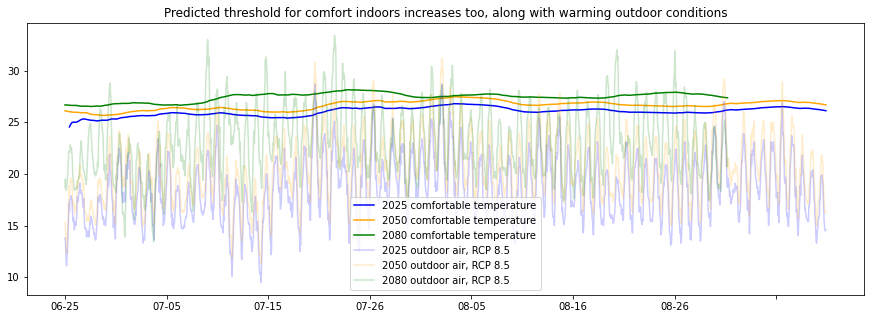

<Figure size 432x288 with 0 Axes>

In [61]:
# The comfortable operative temperature creeps up too...

df_temp = df_85.copy()
df_temp.index = df_temp.index.strftime('%m-%d')

plt.figure(figsize=(15,5))
plt.title('Predicted threshold for comfort indoors increases too, along with warming outdoor conditions')
ax1 = df_temp.loc[(df_85.index.year == 2025),'comfy_opTmp'].plot(marker='', 
                                    linestyle = '-', 
                                    color='blue', 
                                    label='2025 comfortable temperature')
ax2 = df_temp.loc[(df_85.index.year == 2050),'comfy_opTmp'].plot(marker='', 
                                    linestyle = '-', 
                                    color='orange', 
                                    label='2050 comfortable temperature')
ax3 = df_temp.loc[(df_85.index.year == 2080),'comfy_opTmp'].plot(marker='', 
                                    linestyle = '-', 
                                    color='green', 
                                    label='2080 comfortable temperature')

ax4 = df_temp.loc[(df_85.index.year == 2025),'out_air'].plot(marker='', 
                                    linestyle = '-', 
                                    color='blue', alpha = 0.2, 
                                    label='2025 outdoor air, RCP 8.5')
ax5 = df_temp.loc[(df_85.index.year == 2050),'out_air'].plot(marker='', 
                                    linestyle = '-', 
                                    color='orange', alpha = 0.2, 
                                    label='2050 outdoor air, RCP 8.5')
ax6 = df_temp.loc[(df_85.index.year == 2080),'out_air'].plot(marker='', 
                                    linestyle = '-', 
                                    color='green', alpha = 0.2, 
                                    label='2080 outdoor air, RCP 8.5')

plt.legend()
plt.show()
plt.savefig(FIGURES_PATH + '/ts_comfortThresholdIncreases_RCP85.pdf') 

## Summary of all hours (not just occupied times)

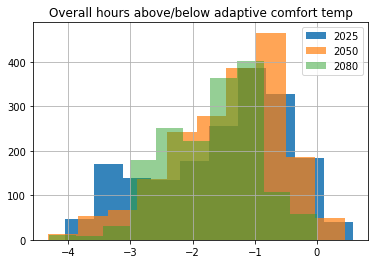

In [62]:
plt.title('Overall hours above/below adaptive comfort temp')
df_85.loc[(df_85.index.year == 2025),('degrees_too_hot')].hist(alpha=0.9, label='2025')
df_85.loc[(df_85.index.year == 2050),'degrees_too_hot'].hist(alpha=0.7, label='2050')
df_85.loc[(df_85.index.year == 2080),'degrees_too_hot'].hist(alpha=0.5, label='2080')
plt.legend()
plt.show()

What is the average 'comfortable' temperature (all hours, not just occupied)?

In [71]:
print('Average upper threshold of comfortable in 2025:',df_85.loc[(df_85.index.year == 2025),'comfy_opTmp'].mean())
print('in 2050:',df_85.loc[(df_85.index.year == 2050),'comfy_opTmp'].mean())
print('And by 2080...:',df_85.loc[(df_85.index.year == 2080),'comfy_opTmp'].mean())

Average upper threshold of comfortable in 2025: 26.026817521354246
in 2050: 26.628264046729136
And by 2080...: 27.434803954629047


What percent of the time is comfortable (all hours, not just occupied)?

In [73]:
# filter to year and when comfy op temp is known
df_85_2025 = df_85.loc[(df_85.index.year == 2025)][df_85['min_VF'].notna()]

# percentage of time comfortable
print('percentage of time comfortable (all hours) in 2025: ', round((df_85_2025.query('too_hot==False').ind_air.count() / df_85_2025.ind_air.shape[0]),2))
 

# filter to year and when comfy op temp is known
df_85_2050 = df_85.loc[(df_85.index.year == 2050)][df_85['min_VF'].notna()]

# percentage of time comfortable
print('percentage of time comfortable (all hours) in 2050: ', round((df_85_2050.query('too_hot==False').ind_air.count() / df_85_2050.ind_air.shape[0]),2))

percentage of time comfortable (all hours) in 2025:  0.96
percentage of time comfortable (all hours) in 2050:  0.98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


## Summary of occupied Hours

In [86]:
# filter to year and when comfy op temp is known
df_85_2025 = df_85.loc[(df_85.index.year == 2025)][df_85['min_VF'].notna()]

# filter to occupied hours
def remove_unoccupied_times(df_allTimes):

    day = df_allTimes.index.dayofweek # Saturday day_of_week = 5 and Sunday_of_week = 6 
    time = df_allTimes.index.hour
    return df_allTimes.iloc[((day != 5) & (day != 6)) & ((time >= 9) & (time <= 17))]

df_85_2025_occ = remove_unoccupied_times(df_85_2025.copy())

# percentage of time comfortable
print('percentage of time comfortable (occupied hours only) in 2025: ', round((df_85_2025_occ.query('too_hot==False').ind_air.count() / df_85_2025_occ.ind_air.shape[0]),2))


# SAME for 2050 
# filter to year and when comfy op temp is known
df_85_2050 = df_85.loc[(df_85.index.year == 2050)][df_85['min_VF'].notna()]

df_85_2050_occ = remove_unoccupied_times(df_85_2050.copy())

# percentage of time comfortable
print('percentage of time comfortable (occupied hours only) in 2050: ', round((df_85_2050_occ.query('too_hot==False').ind_air.count() / df_85_2050_occ.ind_air.shape[0]),2))

print('Average upper threshold of comfortable in 2025:',df_85_2025_occ.loc[(df_85_2025_occ.index.year == 2025),'comfy_opTmp'].mean())
print('in 2050:',df_85_2050_occ.loc[(df_85_2050_occ.index.year == 2050),'comfy_opTmp'].mean())

percentage of time comfortable (occupied hours only) in 2025:  0.91
percentage of time comfortable (occupied hours only) in 2050:  0.94
Average upper threshold of comfortable in 2025: 26.025940328269925
in 2050: 26.627744295634887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Plots 

In 2025 under RCP 8.5, it is too hot about indoors 0.0 percent of the time.


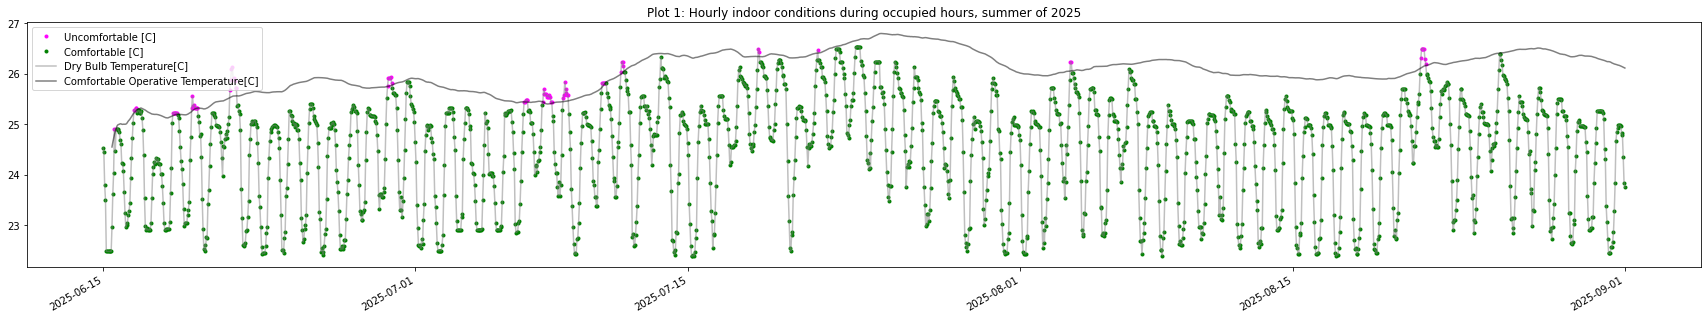

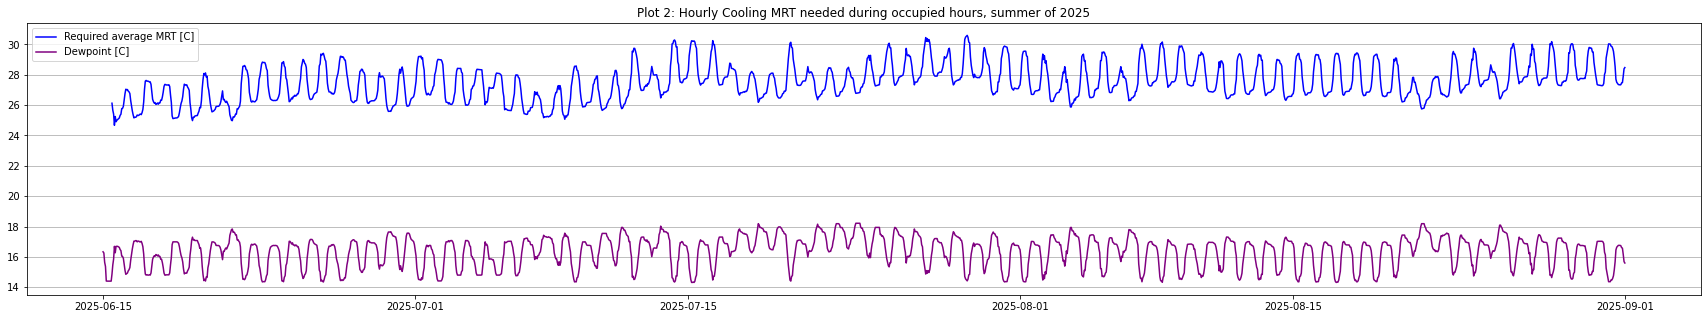

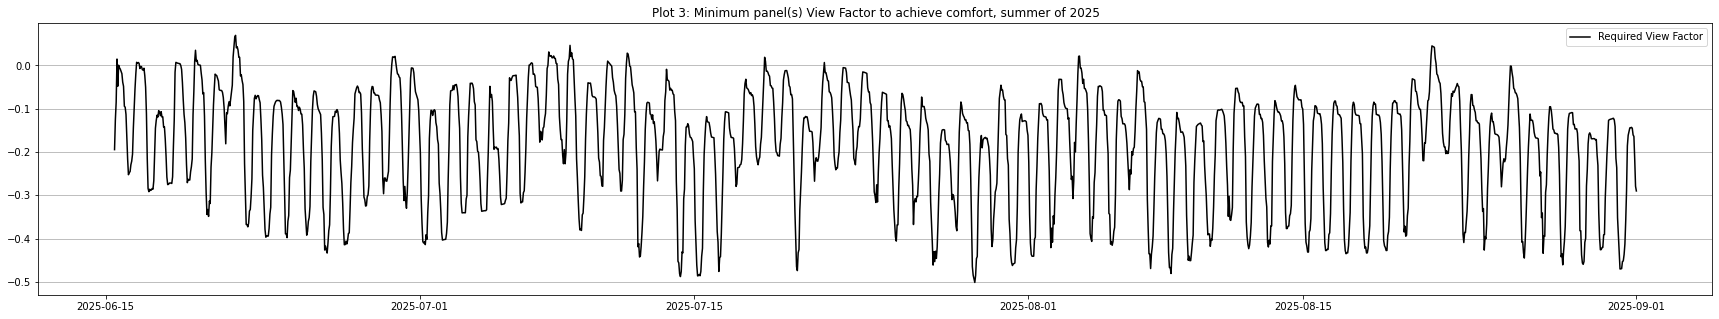

/n
In 2050 under RCP 8.5, it is too hot about indoors 0.0 percent of the time.


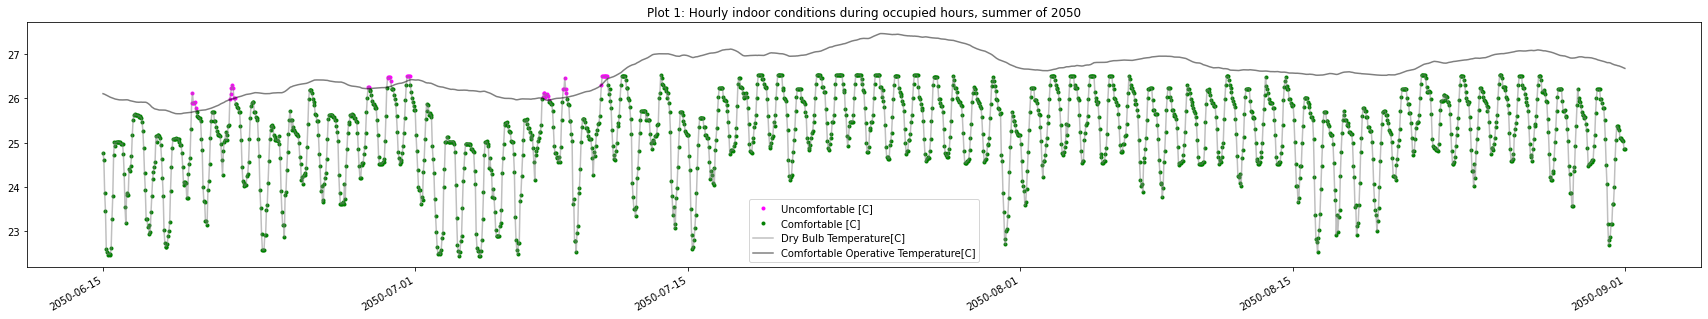

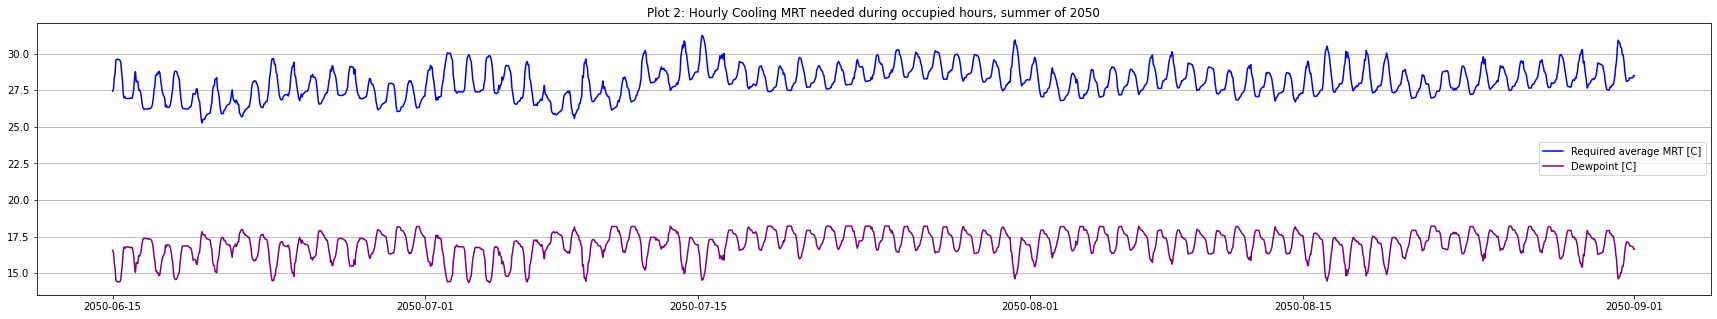

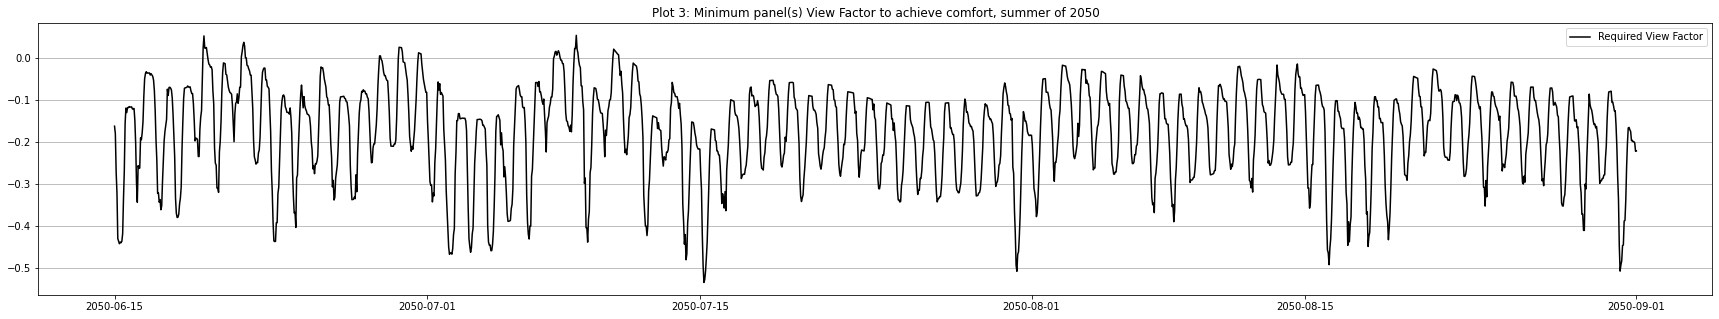

/n
In 2080 under RCP 8.5, it is too hot about indoors 0.0 percent of the time.


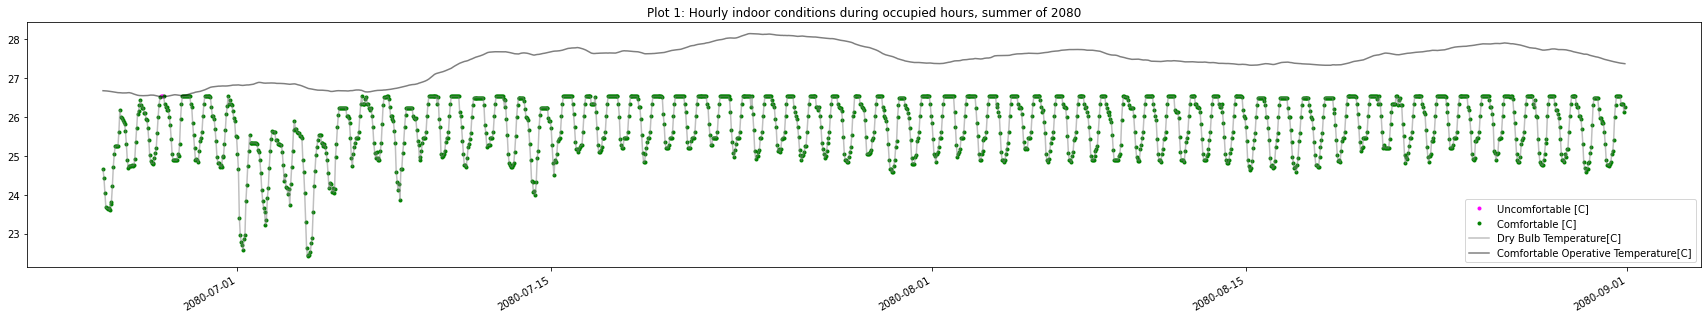

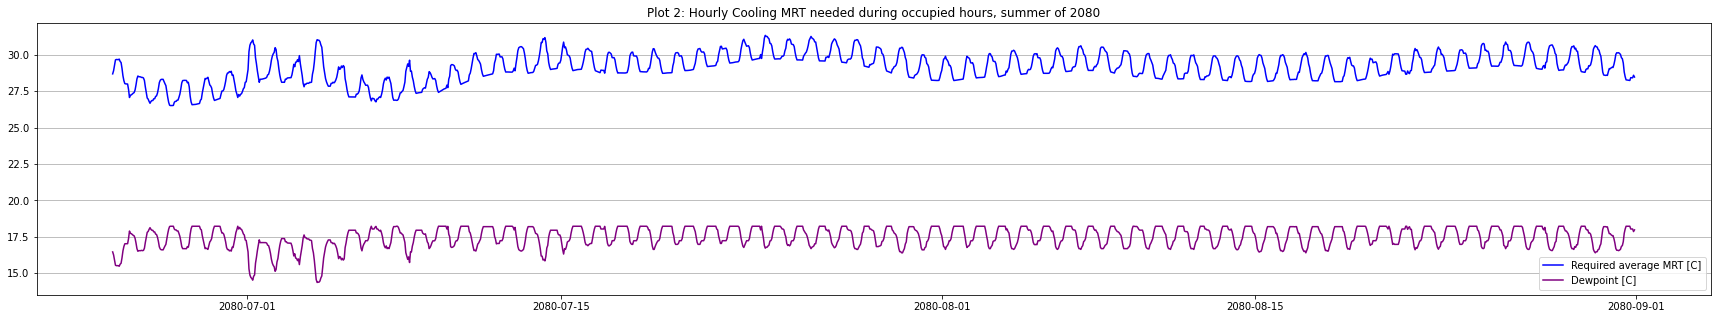

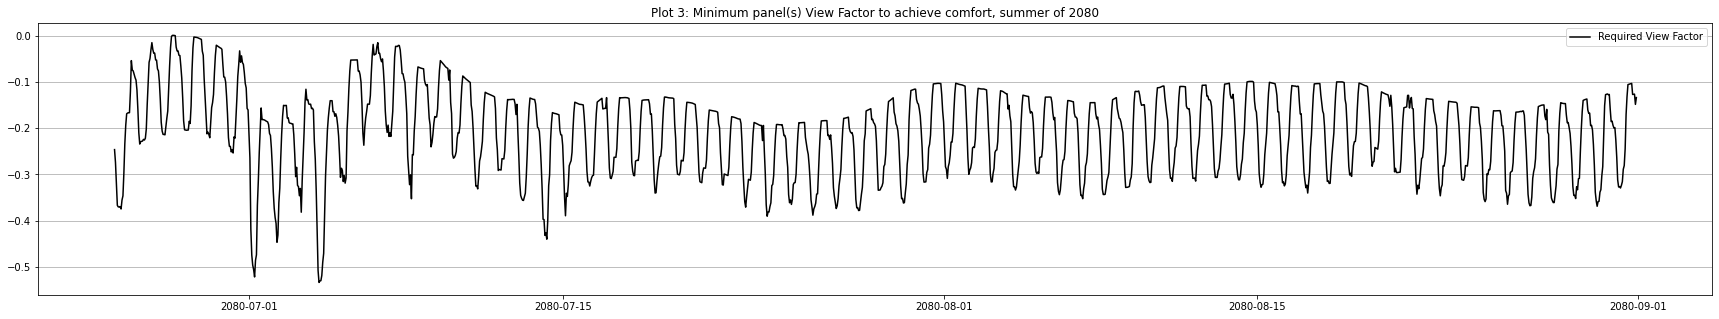

<Figure size 432x288 with 0 Axes>

In [66]:
def visualize_year(dat=df_85, year=2050):
    yr = year
    df_plot = dat.copy()

    # keep only summer dates, e.g., June, July and August:
    df_yr = df_plot[df_plot.index.month.isin([6,7,8]) & (df_plot.index.year == yr)]
    x_ax = df_yr.index

    print('In', yr, 'under RCP 8.5, it is too hot about indoors', df_yr['too_hot'].mean().round(1)*100, 'percent of the time.') 

    # Plot 1: When is it uncomfortably hot? (time series)
    plt.figure(figsize=(30,5))
    plt.title("Plot 1: Hourly indoor conditions during occupied hours, summer of %i" %yr)

    ax1 = df_yr.loc[(df_yr['too_hot'] == True), 
                    'ind_air'].plot(marker='.', 
                                    linestyle = '', 
                                    color='magenta', 
                                    label='Uncomfortable [C]')
    ax2 = df_yr.loc[(df_yr['too_hot'] != True), 
                    'ind_air'].plot(marker='.', 
                                    linestyle = '', 
                                    color='g',
                                    label='Comfortable [C]')
    ax3 = df_yr['ind_air'].plot(marker='', 
                                    linestyle = '-', 
                                    color='gray', 
                                    alpha = 0.5,
                                    label='Dry Bulb Temperature[C]')
    ax4 = df_yr['comfy_opTmp'].plot(marker='', 
                                    linestyle = '-', 
                                    color='black', 
                                    alpha = 0.5,
                                    label='Comfortable Operative Temperature[C]')
        
    #plt.grid(axis='y')
    plt.legend()
    plt.show()

    # Plot 2: MRT needs during summer (time series)
    plt.figure(figsize=(30,5))
    plt.title("Plot 2: Hourly Cooling MRT needed during occupied hours, summer of %i" %yr)
    plt.grid(axis='y')
    plt.plot(x_ax, df_yr.comfy_MRT, 
                  linestyle='-',
                  marker='', color = 'b', 
                  label="Required average MRT [C]")
    plt.plot(x_ax, df_yr.dew_point, 
                  linestyle='-', 
                  marker='', color = 'purple',
                  label="Dewpoint [C]")
    plt.legend()
    plt.show()

    # Plot 3: Minimum VF needs during summer (time series)
    plt.figure(figsize=(30,5))
    plt.title("Plot 3: Minimum panel(s) View Factor to achieve comfort, summer of %i" %yr)
    plt.grid(axis='y')
    plt.plot(x_ax, df_yr.min_VF, 
             linestyle='-', 
             marker='', color = 'black',
             label="Required View Factor")
    plt.legend()
    plt.show()


# Visualize 2025
year=2025
visualize_year(df_85, year)
print('/n')

# Visualize 2050
year = 2050
visualize_year(df_85, year)
print('/n')

# Visualize 2080
year = 2080
visualize_year(df_85, year)

plt.savefig(FIGURES_PATH + '/ts_ALL_RCP85.pdf') 

## Results % of comfortable hours as a function of view factor, year, RCP

show MRT of panels needed to achieve cooling


ALL HOURS:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


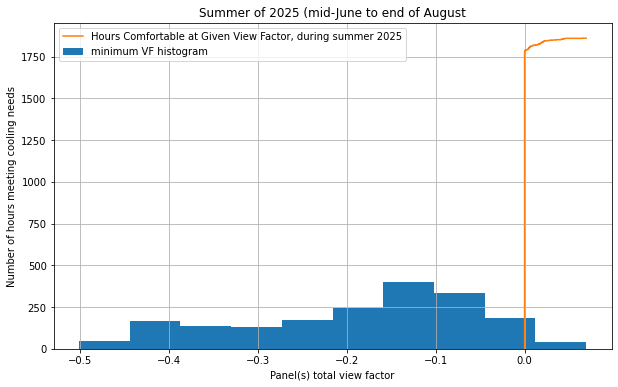

<Figure size 432x288 with 0 Axes>

In [67]:
# filter to year and when comfy op temp is known
df_85_2025 = df_85.loc[(df_85.index.year == 2025)][df_85['min_VF'].notna()]

# look at proportion hours >= given VF 
plt.figure(figsize=(10,6))
df_85_2025.min_VF.hist(label='minimum VF histogram')

# rewrite everything below 0 to 0 (VF below 0 is still 0)
sorted_2025= np.sort(df_85_2025.min_VF) 
sorted_2025[sorted_2025<0.0] = 0

#plot

plt.step(sorted_2025, np.arange(sorted_2025.size), label='Hours Comfortable at Given View Factor, during summer 2025') 
plt.title("ALL HOURS Summer of 2025 (mid-June to end of August")
plt.xlabel('Panel(s) total view factor')
plt.ylabel('Number of hours meeting cooling needs')
plt.legend()
plt.show()

plt.savefig(FIGURES_PATH + '/cumsum_timeComf_vs_VF_2025_RCP85.pdf') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


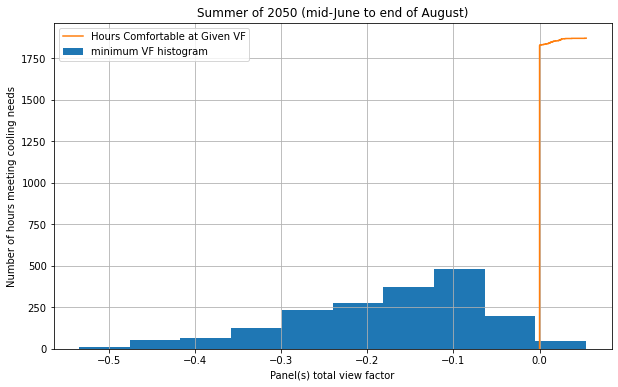

<Figure size 432x288 with 0 Axes>

In [68]:
# filter to year and when comfy op temp is known
df_85_2050 = df_85.loc[(df_85.index.year == 2050)][df_85['min_VF'].notna()]

# look at proportion hours >= given VF 
plt.figure(figsize=(10,6))
df_85_2050.min_VF.hist(label='minimum VF histogram')

# rewrite everything below 0 to 0 (VF below 0 is still 0)
sorted_2050= np.sort(df_85_2050.min_VF) 
sorted_2050[sorted_2050<0.0] = 0

#plot 
plt.step(sorted_2050, np.arange(sorted_2050.size), label='Hours Comfortable at Given VF') 
plt.title("ALL HOURS Summer of 2050 (mid-June to end of August)")
plt.xlabel('Panel(s) total view factor')
plt.ylabel('Number of hours meeting cooling needs')
plt.legend()
plt.show()

plt.savefig(FIGURES_PATH + '/cumsum_timeComf_vs_VF_2050_RCP85.pdf') 

OCCUPIED HOURS ONLY

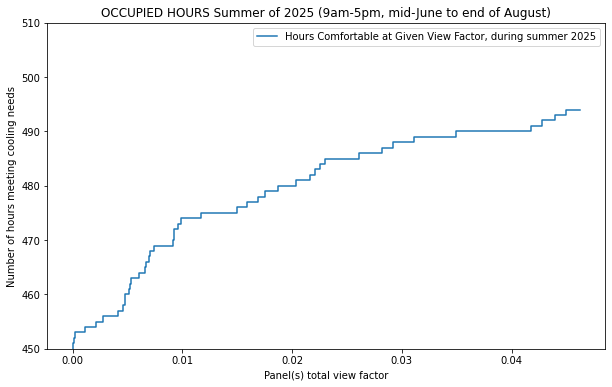

<Figure size 432x288 with 0 Axes>

In [92]:
# look at proportion hours >= given VF 
plt.figure(figsize=(10,6))

# rewrite everything below 0 to 0 (VF below 0 is still 0)
sorted_2025= np.sort(df_85_2025_occ.min_VF) 
sorted_2025[sorted_2025<0.0] = 0

#plot

plt.step(sorted_2025, np.arange(sorted_2025.size), label='Hours Comfortable at Given View Factor, during summer 2025') 
plt.title("OCCUPIED HOURS Summer of 2025 (9am-5pm, mid-June to end of August)")
plt.xlabel('Panel(s) total view factor')
plt.ylabel('Number of hours meeting cooling needs')
plt.legend()
plt.ylim(450, 510)
plt.show()

plt.savefig(FIGURES_PATH + '/cumsum_timeComf_vs_VF_2025_RCP85_occHrs.pdf') 

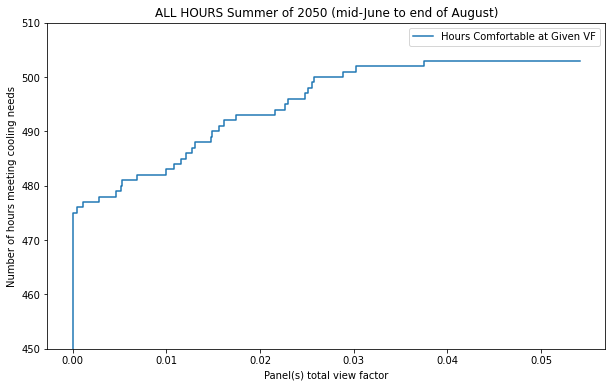

<Figure size 432x288 with 0 Axes>

In [91]:
#  2050

# look at proportion hours >= given VF 
plt.figure(figsize=(10,6))

# rewrite everything below 0 to 0 (VF below 0 is still 0)
sorted_2050= np.sort(df_85_2050_occ.min_VF) 
sorted_2050[sorted_2050<0.0] = 0

#plot 
plt.step(sorted_2050, np.arange(sorted_2050.size), label='In 2050, Hours Comfortable at Given VF') 
plt.title("OCCUPIED HOURS Summer of 2050 (mid-June to end of August)")
plt.xlabel('Panel(s) total view factor')
plt.ylabel('Number of hours meeting cooling needs')
plt.legend()
plt.ylim(450, 510)
plt.show()

plt.savefig(FIGURES_PATH + '/cumsum_timeComf_vs_VF_2050_RCP85_occHrs.pdf') 

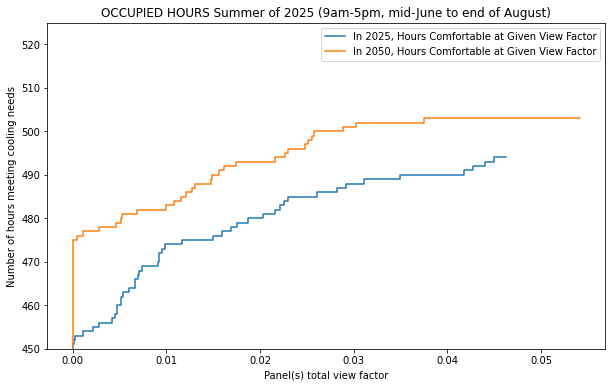

In [94]:
# look at proportion hours >= given VF 
plt.figure(figsize=(10,6))

# rewrite everything below 0 to 0 (VF below 0 is still 0)
sorted_2025= np.sort(df_85_2025_occ.min_VF) 
sorted_2025[sorted_2025<0.0] = 0 

sorted_2050= np.sort(df_85_2050_occ.min_VF) 
sorted_2050[sorted_2050<0.0] = 0

#plot

plt.step(sorted_2025, np.arange(sorted_2025.size), label='In 2025, Hours Comfortable at Given View Factor') 
plt.step(sorted_2050, np.arange(sorted_2050.size), label='In 2050, Hours Comfortable at Given View Factor') 

plt.title("OCCUPIED HOURS Summer of 2025 (9am-5pm, mid-June to end of August)")
plt.xlabel('Panel(s) total view factor')
plt.ylabel('Number of hours meeting cooling needs')
plt.legend()
plt.ylim(450, 525)
plt.show()



## Notes to Self: 
*    Quantify what panel MRT 'needs to be' (i.e., our model calc) to keep things comfortable for typical VFs... draw from scenarios perhaps using Dorit's paper... then show how often (and when) this drops below the estimated dew point (in recorded years and in future years).
*   More detailed analysis:  how often (and when) does the MEMBRANE drop below the estimated dew point? 
*    AND how much energy would it take to keep occupants comfy PER OCCUPANT and TOTAL? (how 

* Ultimately, metric to calculate: % of comfortable hours as a function of view factor, year, climate change 
* Could we estimate the error of this 'end-to-end' prediction? Where is the error largest? (e.g., model of outdoor-indoor, weather inputs of future climate versus comfort model versus inherennt VF?) 

 check wheather we really want weather: https://www.weathershift.com/purchase/
 https://services.pacificclimate.org/wx-files/app/

 check adaptive method model at https://comfort.cbe.berkeley.edu








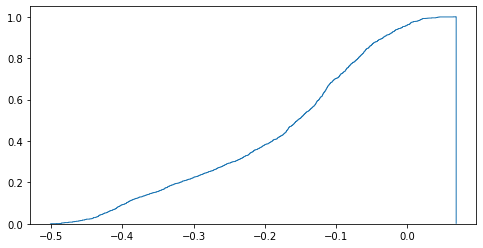

In [70]:
# plot the cumulative histogram starting at VF >= 0: 
sorted_data = np.sort(df_85_2025.min_VF)
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(sorted_data, sorted_data.size, density=True, histtype='step',
                           cumulative=True, label='Empirical')

In [75]:
# Fraction of Occupied Hours Only
# keep only summer dates, e.g., June, July and August, during occupied hours (Mon-Fri, 9-5)
df_85_2050_occHrs = df_85_2050[(df_85_2050.index.month.isin([6,7,8]))  & (df_85_2050.index.hour >= 9) & (df_85_2050.index.hour <= 17) & (df_85_2050.index.dayofweek.isin([0,1,2,3,4]))] 
df_85_2025_occHrs = df_85_2025[(df_85_2025.index.month.isin([6,7,8]))  & (df_85_2025.index.hour >= 9) & (df_85_2025.index.hour <= 17) & (df_85_2025.index.dayofweek.isin([0,1,2,3,4]))] 
 

# Write hours as percent time   


# Put all years onto same graph (drop histogram)

Approximation of actual background MRT (as different from desired background to maintain comfortable conditions)#

Notes
 approximation of dew point temperature if you know the observed temperature and relative humidity

Td = T - ((100 - RH)/5.)

where Td is dew point temperature (in degrees Celsius), T is observed temperature (in degrees Celsius), and RH is relative humidity (in percent). Apparently this relationship is fairly accurate for relative humidity values above 50%.

More details can be found in the article:

Lawrence, Mark G., 2005: The relationship between relative humidity and the dewpoint temperature in moist air: A simple conversion and applications. Bull. Amer. Meteor. Soc., 86, 225-233. doi: http;//dx.doi.org/10.1175/BAMS-86-2-225


Next steps#
Run with future outdoor air temps on same building.
Run with this summer's air temps? 

In parallel: how to quantify and best communicate level of 'error' and level of 'uncertainty' 